In [1]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [1]:
#!pip install spanda

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm
import timm
from sklearn.metrics import r2_score

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, Analytes, SpectraTfm, 
                                    TrimTfm, AnalytesTfm, SNVTfm, AvgTfm, GADFTfm, 
                                    AvgBatchTfm, GADFBatchTfm, To3DTfm, ResizeTfm, LogTfm)


use_cuda = torch.cuda.is_available()
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings('ignore')


analyte_name = 'K'

## Configs

In [4]:
root_dir = Path('../../_data/') if device != 'cuda' else Path('.')

## Utilities

In [5]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [5]:
def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return L(paths)

In [2]:
def get_dls(paths, analytes=['725'], bs=32, seed=42):
    get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
    get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

    dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=analytes)),
                       get_x=get_spectra,
                       get_y=get_target,
                       splitter=RandomSplitter(valid_pct=0.2, seed=seed),
                       item_tfms=[AvgTfm],
                       batch_tfms=[GADFBatchTfm,  ResizeTfm,
                                   LogTfm])

    return dblock.dataloaders(paths, bs=bs, num_workers=6)

## Data loading

In [3]:
analytes = ['725'] # Kex

In [10]:
paths_kssl = get_paths(root_dir/'kssl-vnir', analytes=analytes)

100%|██████████| 20949/20949 [00:16<00:00, 1262.00it/s]


In [13]:
dls = get_dls(paths_kssl, bs=16)

In [14]:
dls.one_batch()[0].shape

torch.Size([16, 1, 256, 256])

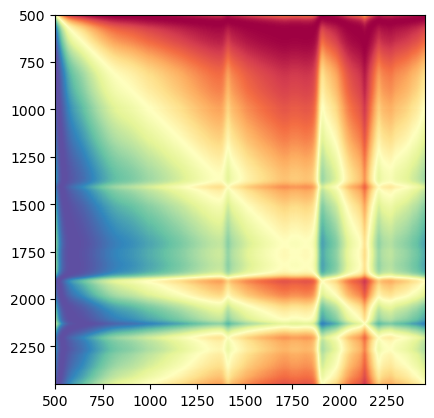

In [34]:
plt.imshow(dls.one_batch()[0][0].squeeze().cpu(), cmap='Spectral', 
           origin='upper', extent=[500,2450,2450,500]);

## Training KSSL

In [35]:
learn = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=1).to_fp16()

In [36]:
learn.summary()

Sequential (Input shape: 64 x 1 x 1951 x 1951)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 976 x 976 
Conv2d                                    3136       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 488 x 488 
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                    

In [37]:
learn.lr_find()

In [6]:
# Only samples with spectra
path = Path('../../_data/lucas-vnir')
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|██████████| 21782/21782 [00:01<00:00, 16343.51it/s]

n samples: 21782


In [ ]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [ ]:
# Only strictly positive measurements
paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=[analyte_name])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')

100%|████████████████████████████████████████████████████████| 21782/21782 [00:16<00:00, 1326.25it/s]

n samples: 21779


In [7]:
class Lucas2KSSLTfm(Transform):        
    def encodes(self, 
                y:Analytes
               ):
        m_k = 39.0983
        return y/(m_k*10)

In [41]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   #item_tfms=[AvgTfm, GADFTfm, ResizeTfm,
                   #           Lucas2KSSLTfm, LogTfm])
                #    item_tfms=[LogTfm],
                   batch_tfms=[AvgBatchTfm, GADFBatchTfm, 
                               LogTfm])

dls = dblock.dataloaders(paths[:n_smp], bs=32, num_workers=6)
#dls.show_batch()

In [43]:
dls.one_batch()[1].shape

torch.Size([32, 1])

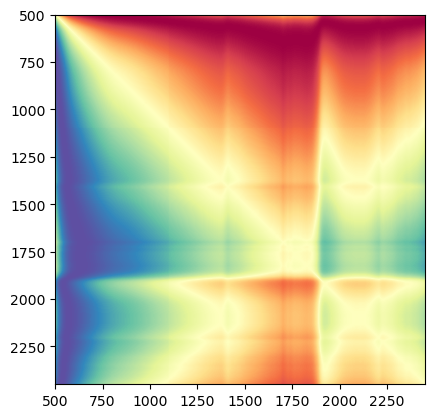

In [30]:
plt.imshow(dls.one_batch()[0][1].squeeze(), cmap='Spectral', 
           origin='upper', extent=[500,2450,2450,500]);

In [ ]:
learn = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=1).to_fp16()

In [ ]:
learn.summary()

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Sequential (Input shape: 32 x 1 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    3136       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                                                       
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=0.0002290867705596611)

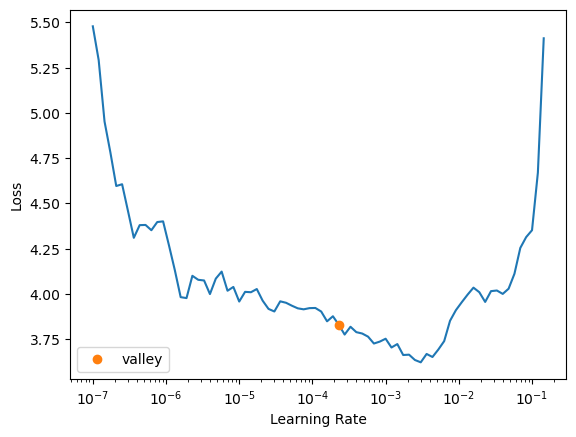

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(3, 2e-4)

In [ ]:
#learn.save('xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323')

Path('models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth')

## Cubist baseline

In [ ]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=[AvgTfm, SNVTfm,
                              Lucas2KSSLTfm, LogTfm])

dls = dblock.dataloaders(paths[:n_smp], bs=32, num_workers=6)

In [ ]:
def asTabular(dls, n=1):
    xs, ys = [], []
    for i in range(n):
        for x, y in tqdm(dls):
            xs.append(x)
            ys.append(y)
    return (torch.cat(ds).squeeze().numpy() for ds in (xs, ys))

In [ ]:
(X_train, y_train) = asTabular(dls.train)

100%|██████████████████████████████████████████████████████████████| 544/544 [01:02<00:00,  8.72it/s]


In [ ]:
X_train.shape

(17408, 3901)

In [ ]:
def plot_spectra(X, X_names, sample=50, alpha=0.8, color='#333', figsize=(20, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    idx = np.random.randint(X.shape[0], size=sample)
    #ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.locator_params(axis="x", nbins=20)
    plt.xlabel('Wavenumber')
    plt.ylabel('Absorbance')
    _ = ax.plot(X_names, X[idx, :].T, lw=1, c=color, alpha=alpha)

In [ ]:
X_names = np.arange(500, 2450+0.5, 0.5)

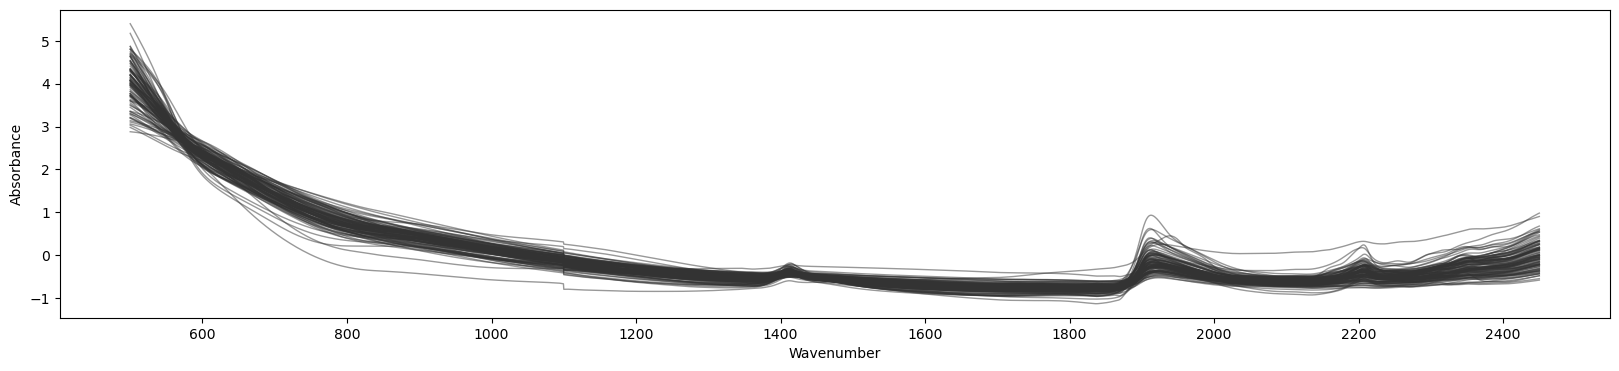

In [ ]:
plot_spectra(X_train, X_names, sample=100, alpha=0.5)

In [ ]:
(X_valid, y_valid) = asTabular(dls.valid)

100%|██████████████████████████████████████████████████████████████| 137/137 [00:16<00:00,  8.43it/s]


In [ ]:
?Cubist

In [ ]:
len(X_train)

17408

In [ ]:
# For testing purpose only
np.random.seed(42)

n_train = 100
idx_train= np.random.choice(np.arange(len(X_train)), size=n_train, replace=False)

n_valid = 20
idx_valid = np.random.choice(np.arange(len(X_valid)), size=n_valid, replace=False)

In [ ]:
models = []
n_committees = [5, 10, 15, 20]
neighbors = range(2,10)


In [ ]:
len(neighbors)

8

In [ ]:
%%time
model = Cubist(n_committees=5, neighbors=5, composite='auto')
model.fit(X_train[idx_train, :], y_train[idx_train])
#model.predict(X)
model.score(X_valid[idx_valid,:], y_valid[idx_valid])

UsageError: Line magic function `%%time` not found.


In [ ]:
%%time
model = Cubist(n_committees=5, neighbors=5, composite='auto')
model.fit(X_train, y_train)
#model.predict(X)
model.score(X_valid, y_valid)

CPU times: user 35min 49s, sys: 1min 33s, total: 37min 23s
Wall time: 37min 33s


0.6156941892293932

In [ ]:
?Cubist

In [ ]:
%%time
model.score(X_train, y_train)

CPU times: user 2min 52s, sys: 1min 22s, total: 4min 14s
Wall time: 4min 26s


0.6858371107997181

In [ ]:
%%time
model.score(X_train, y_train)

CPU times: user 2min 51s, sys: 1min 18s, total: 4min 9s
Wall time: 4min 18s


0.6858371107997181